In [22]:
"""Imports"""

import re
import json
from os import listdir
from os.path import isfile
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from config import *


In [23]:
"""Define functions used in analysing and plotting results"""

def filter_res_by_cut_number(cut_number, res_data):

    output = []
    for d in res_data:
        if d['number_of_cuts'] == cut_number:
            output.append(d)
    return output


def normalize_to_exhaustive_search(res_data, keep_exhaustive_search=False):

    # Initialize a dictionary to hold the sum of output values and count for each item
    item_outputs = {}

    # Loop through the dataset to group them based on sequence and cut number
    for d in res_data:
        key = (d["number_of_cuts"], d["sequence"])
        if key not in set(item_outputs.keys()):
            item_outputs[key] = [d]
        if d not in item_outputs[key]:
            item_outputs[key].append(d)

    # Aggregate each group to one dict
    output = []
    for lst in item_outputs.values():
        time_of_each_method = {d['partition_search_method']: d['elapsed_time'] for d in lst}
        for d in lst:
            out_d = d.copy()
            out_d.update({"normalized":d["elapsed_time"]/time_of_each_method["no_cost_scan"]})
            output.append(out_d)

    if not keep_exhaustive_search:
        output = [d for d in output if d['partition_search_method'] != 'no_cost_scan']

    return output


def scattered_plot(x_axis, res_data, cut_number_range):

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(16, 6))
    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(24, 6))
    plt.subplots_adjust(wspace=0.5)
    fig.patch.set_facecolor('white')  # Set the background of the figure to white
    colors = sns.color_palette("flare", len(cut_number_range))
    color_map = {i+1:color for i,color in zip(cut_number_range,colors)}
    y_lims = {'DFS':[0.5,1000],
              'NFS':[0.5,1000]}

    for ax, search_method in zip((ax1, ax2), ["DFS", "NFS"]):
    # for ax, search_method in zip((ax1, ax2, ax3), ["DFS", "BFS", "NFS"]):
        normalized_res = normalize_to_exhaustive_search(res_data, keep_exhaustive_search=True)
        df = pd.DataFrame([d for d in normalized_res if d['partition_search_method'] == search_method and d['number_of_cuts'] in cut_number_range])

        grouped = df.groupby('number_of_fragments')
        for key, group in grouped:
            sns.regplot(ax=ax,
                        x=group['seq_length'],
                        # y=group['elapsed_time'],
                        y=group['normalized_to_bfs'],
                        scatter=True,
                        label=key,
                        color=color_map[key],
                        scatter_kws={'alpha':0.8,'s':5},
                        line_kws={'linewidth':1.5})

        ax.set_ylabel(f"{search_method} Search Time / BFS Search Time")
        # ax.set_ylabel(f"{search_method} Search Time in Min.")
        ax.set_xlabel(str.title(re.sub('_',' ',x_axis)))
        ax.legend(title='Number of Fragments', loc='upper left', ncols=2)
        ax.set_yscale('log')
        ax.set_facecolor('white')  # Set the background of the axes to white
        ax.set_ylim([0.01,1700])
        ax.set_ylim(y_lims[search_method])
        ax.set_title(f'Search Time Improvement per Seq Length and Cut Number \n'
                     f'\n '
                     f'BFS vs. {search_method}')
        # ax.set_title(f'Search Time per Seq Length and Fragment Number \n'
        #      f'\n '
        #      f'{search_method}')

        sel_param = "normalized_to_bfs"
        # sel_param = "elapsed_time"
        max_y = max(df[sel_param].values)
        for idx, (x, y) in enumerate(zip(df[x_axis].values,df[sel_param].values)):
            if y == max_y:
                ax.annotate(f"{round(y, 2)}", (x, y))

    return plt


def jitter_box_plot(x_axis, y_axis, df, my_palette, logy=True):

    plt.figure(figsize=(6, 4))
    if logy:
        plt.yscale('log')
    else:
        plt.yscale('linear')

    # Using seaborn to plot with jitter and boxplot
    sns.boxplot(x=x_axis, y=y_axis, hue='partition_search_method', data=df, palette='dark:white', showfliers = False,
                boxprops=dict(facecolor='white', edgecolor="black"))
    sns.stripplot(x=x_axis, y=y_axis, hue='partition_search_method', data=df, palette=my_palette, dodge=True,
                  jitter=True, alpha=0.5, edgecolor='auto')
    plt.xlabel(str.title(re.sub('_',' ',x_axis)))
    if y_axis == "normalized":
        plt.ylabel(f"Elapsed Time {str.title(re.sub('_',' ',y_axis))}")
    else:
        plt.ylabel(f"{str.title(re.sub('_',' ',y_axis))}")
    plt.title(f'Jittered Scatter Plot with Boxplot by Search Method and {str.title(re.sub("_"," ",x_axis))}')

    # Adjust legend to avoid duplicate entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    legend = plt.legend(by_label.values(), by_label.keys(), title='Search Method', loc='upper left')
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor((0, 0, 0, 0))

    return plt

In [24]:
"""Import and prepare data"""

result_dirs = [
    r"C:\Users\GOFKV\PycharmProjects\cookie_cutter\experiments\partition_search_opt\input75_cost_scan",
    r"C:\Users\GOFKV\PycharmProjects\cookie_cutter\experiments\partition_search_opt\input75_distribute_mut_cost_scan",
    r"C:\Users\GOFKV\PycharmProjects\cookie_cutter\experiments\partition_search_opt\input75_distribute_mut",
    r"C:\Users\GOFKV\PycharmProjects\cookie_cutter\experiments\partition_search_opt\input75_no_cost_scan",
    r"C:\Users\GOFKV\PycharmProjects\cookie_cutter\experiments\partition_search_opt\input75_1_mut_distribution",
    r"C:\Users\GOFKV\PycharmProjects\cookie_cutter\experiments\partition_search_opt\input75_all"
]

result_files = [join(result_dir, "results", f)
                for result_dir in result_dirs
                for f in listdir(join(result_dir, "results")) if isfile(join(result_dir,"results", f)) and re.search('best_partitions_by_cut_number',f)]

print(result_files)

res_data = []
for file_path in result_files:
    name = re.search("input75.+?\\\\",file_path).group()
    name = re.sub("\\\\|input75_","",name)
    if name == "all":
        name = re.sub("^.+best_partitions_by_cut_number_|[.]json","",file_path)
    with open(file_path, 'r') as fp:
        res_dict = json.load(fp)
        for res_per_cut in res_dict["best_partitions_by_cut_number"]:
            res_dict_ = res_dict.copy()
            number_checked = res_per_cut["number_of_partitions_checked"]
            hard_constraint_violations = sum([v for v in res_per_cut["hard_constraint_violations"].values()])
            if len(res_per_cut["sel_partitions"]) > 0:
                ligation_fidelity = res_per_cut["sel_partitions"][0]["ligation_fidelity"]
                fragment_length_unevenness = res_per_cut["sel_partitions"][0]["fragment_length_unevenness"]
                cost = res_per_cut["sel_partitions"][0]["cost"]
            else:
                ligation_fidelity = fragment_length_unevenness = cost = float("nan")
            res_dict_.update({
                'partition_search_method':name,
                'seq_length':len(res_dict["sequence"]),
                'mutation_positions':len(res_dict["mutations"]),
                'number_of_cuts':res_per_cut['number_of_cuts'],
                'number_of_fragments':res_per_cut['number_of_cuts']+1,
                'elapsed_time':res_per_cut['elapsed_time']/60,
                "ligation_fidelity":ligation_fidelity,
                "fragment_length_unevenness":fragment_length_unevenness,
                "cost":cost,
                "number_of_partitions_checked":number_checked,
                "pass_constraint_percentage": (number_checked-hard_constraint_violations)/number_checked * 100
                             })
            res_dict_.pop("best_partitions_by_cut_number", None)
            res_dict_.pop("mutations", None)
            res_data.append(res_dict_)


['C:\\Users\\GOFKV\\PycharmProjects\\cookie_cutter\\experiments\\partition_search_opt\\input75_cost_scan\\results\\best_partitions_by_cut_number_1.json', 'C:\\Users\\GOFKV\\PycharmProjects\\cookie_cutter\\experiments\\partition_search_opt\\input75_distribute_mut_cost_scan\\results\\best_partitions_by_cut_number_1.json', 'C:\\Users\\GOFKV\\PycharmProjects\\cookie_cutter\\experiments\\partition_search_opt\\input75_distribute_mut\\results\\best_partitions_by_cut_number_1.json', 'C:\\Users\\GOFKV\\PycharmProjects\\cookie_cutter\\experiments\\partition_search_opt\\input75_no_cost_scan\\results\\best_partitions_by_cut_number_1.json', 'C:\\Users\\GOFKV\\PycharmProjects\\cookie_cutter\\experiments\\partition_search_opt\\input75_1_mut_distribution\\results\\best_partitions_by_cut_number_distribute_mut_1.json', 'C:\\Users\\GOFKV\\PycharmProjects\\cookie_cutter\\experiments\\partition_search_opt\\input75_all\\results\\best_partitions_by_cut_number_1_mut_distribution.json', 'C:\\Users\\GOFKV\\Pych

C:\Users\GOFKV\AppData\Local\Temp\ipykernel_15500\1394385475.py:104: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.stripplot(x=x_axis, y=y_axis, hue='partition_search_method', data=df, palette=my_palette, dodge=True,


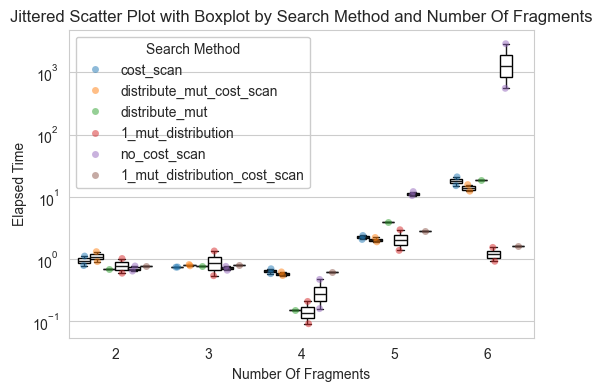

C:\Users\GOFKV\AppData\Local\Temp\ipykernel_15500\1394385475.py:104: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.stripplot(x=x_axis, y=y_axis, hue='partition_search_method', data=df, palette=my_palette, dodge=True,


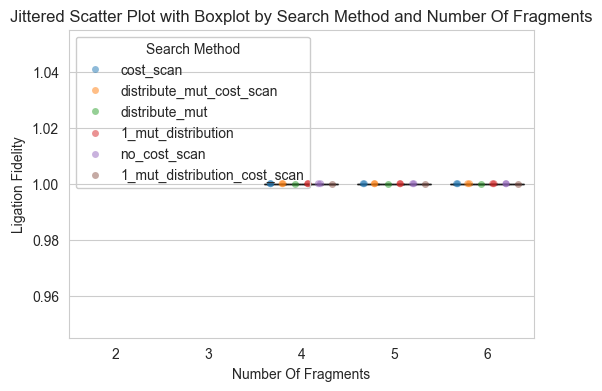

C:\Users\GOFKV\AppData\Local\Temp\ipykernel_15500\1394385475.py:104: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.stripplot(x=x_axis, y=y_axis, hue='partition_search_method', data=df, palette=my_palette, dodge=True,


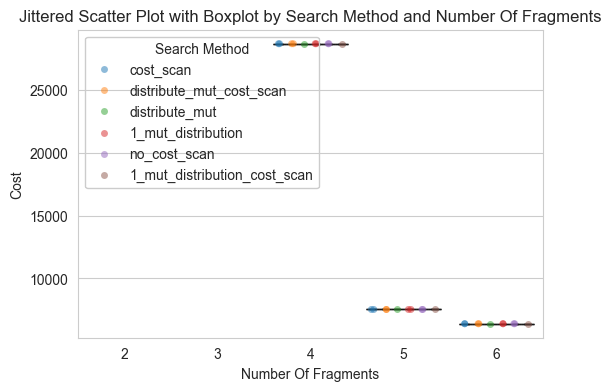

C:\Users\GOFKV\AppData\Local\Temp\ipykernel_15500\1394385475.py:104: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.stripplot(x=x_axis, y=y_axis, hue='partition_search_method', data=df, palette=my_palette, dodge=True,


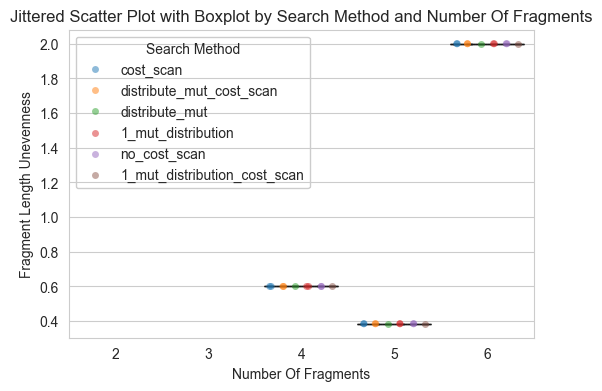

C:\Users\GOFKV\AppData\Local\Temp\ipykernel_15500\1394385475.py:104: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.stripplot(x=x_axis, y=y_axis, hue='partition_search_method', data=df, palette=my_palette, dodge=True,


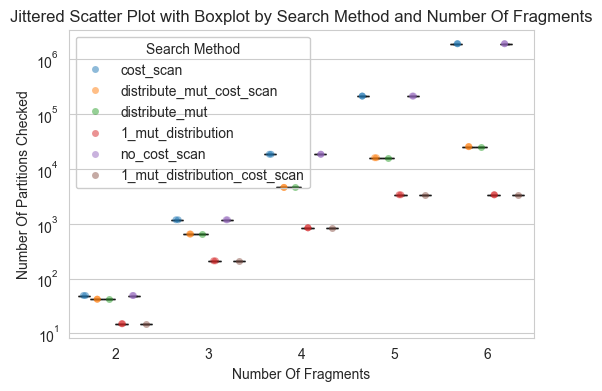

C:\Users\GOFKV\AppData\Local\Temp\ipykernel_15500\1394385475.py:104: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.stripplot(x=x_axis, y=y_axis, hue='partition_search_method', data=df, palette=my_palette, dodge=True,


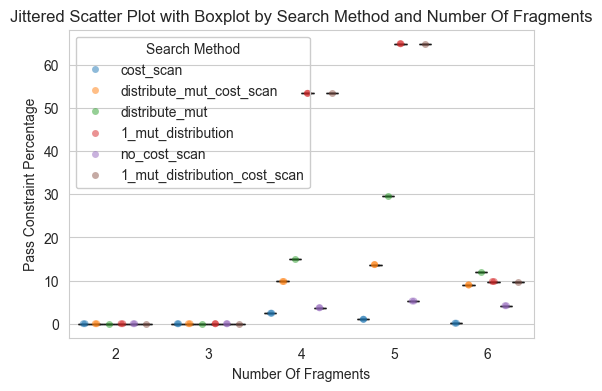

In [25]:
"""Plotting - Jitter + Box Plots"""

# my_palette = sns.color_palette(["#55a868","#4c72b0","#c44e52"])
my_palette = sns.color_palette()

# for x_axis in ['number_of_fragments','seq_length']:
for x_axis in ['number_of_fragments']:
    # for y_axis in ["elapsed_time", "normalized_to_bfs"]:
    for y_axis, logy in zip(["elapsed_time","ligation_fidelity", "cost", "fragment_length_unevenness","number_of_partitions_checked","pass_constraint_percentage"],[True, False, False, False, True, False]):
        if y_axis == "normalized":
            df = pd.DataFrame(normalize_to_exhaustive_search(res_data, keep_exhaustive_search=True))
        else:
            df = pd.DataFrame(res_data)
        df['partition_search_method'] = pd.Categorical(df['partition_search_method'],
                                                       ["cost_scan",
                                                        "distribute_mut_cost_scan",
                                                        "distribute_mut",
                                                        "1_mut_distribution",
                                                        "no_cost_scan",
                                                        "1_mut_distribution_cost_scan"])
        df = df.sort_values("partition_search_method")
        plt = jitter_box_plot(x_axis, y_axis, df, my_palette, logy=logy)
        plt.show()


KeyError: 'number_of_fragments'

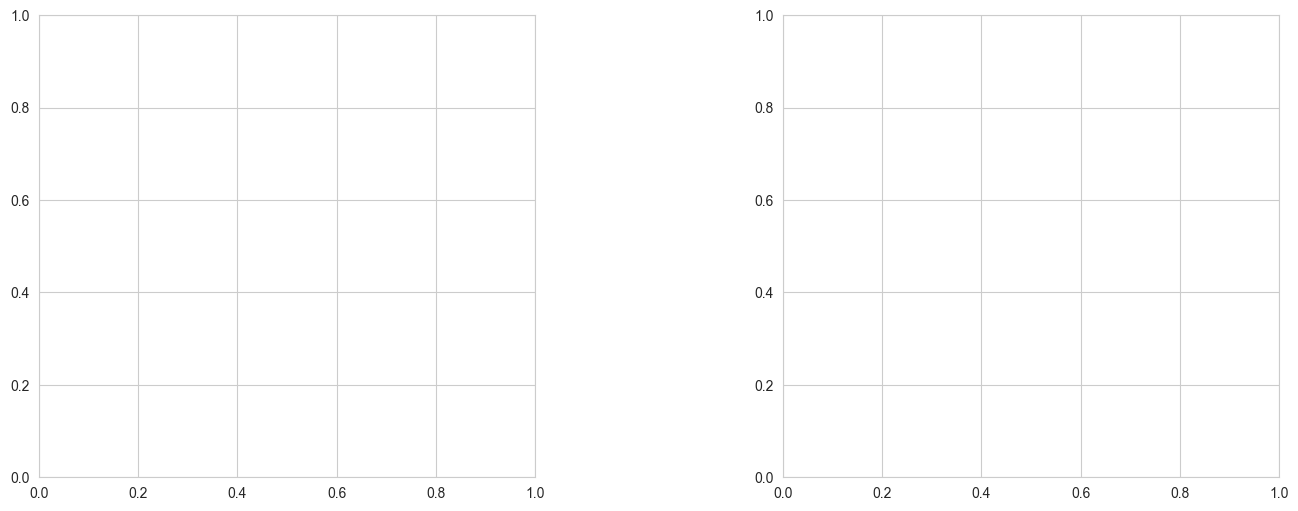

In [26]:
"""Plotting - Scatter Plots"""

plt = scattered_plot(x_axis='seq_length', res_data=res_data, cut_number_range=range(0,6))
plt.show()